In [1]:
import sys
sys.path.append('/Users/visheshyadav/Documents/GitHub/CoreRec')
from SANDBOX.nidar import *

Processing...
Done!


Epoch 0, Loss: 1.1220203638076782
Epoch 1, Loss: 1.1147853136062622
Epoch 2, Loss: 1.1073832511901855
Epoch 3, Loss: 1.1037174463272095
Epoch 4, Loss: 1.0951416492462158
Epoch 5, Loss: 1.104994535446167
Epoch 6, Loss: 1.1057488918304443
Epoch 7, Loss: 1.108786702156067
Epoch 8, Loss: 1.1058744192123413
Epoch 9, Loss: 1.0895556211471558
Epoch 10, Loss: 1.094239592552185
Epoch 11, Loss: 1.0798872709274292
Epoch 12, Loss: 1.101089358329773
Epoch 13, Loss: 1.093509316444397
Epoch 14, Loss: 1.1050639152526855
Epoch 15, Loss: 1.0999844074249268
Epoch 16, Loss: 1.0969678163528442
Epoch 17, Loss: 1.1040451526641846
Epoch 18, Loss: 1.0963879823684692
Epoch 19, Loss: 1.0870862007141113
Epoch 20, Loss: 1.0896273851394653
Epoch 21, Loss: 1.0958092212677002
Epoch 22, Loss: 1.0952833890914917
Epoch 23, Loss: 1.0871691703796387
Epoch 24, Loss: 1.0950236320495605
Epoch 25, Loss: 1.0923199653625488
Epoch 26, Loss: 1.0876758098602295
Epoch 27, Loss: 1.091068983078003
Epoch 28, Loss: 1.0902470350265503
E

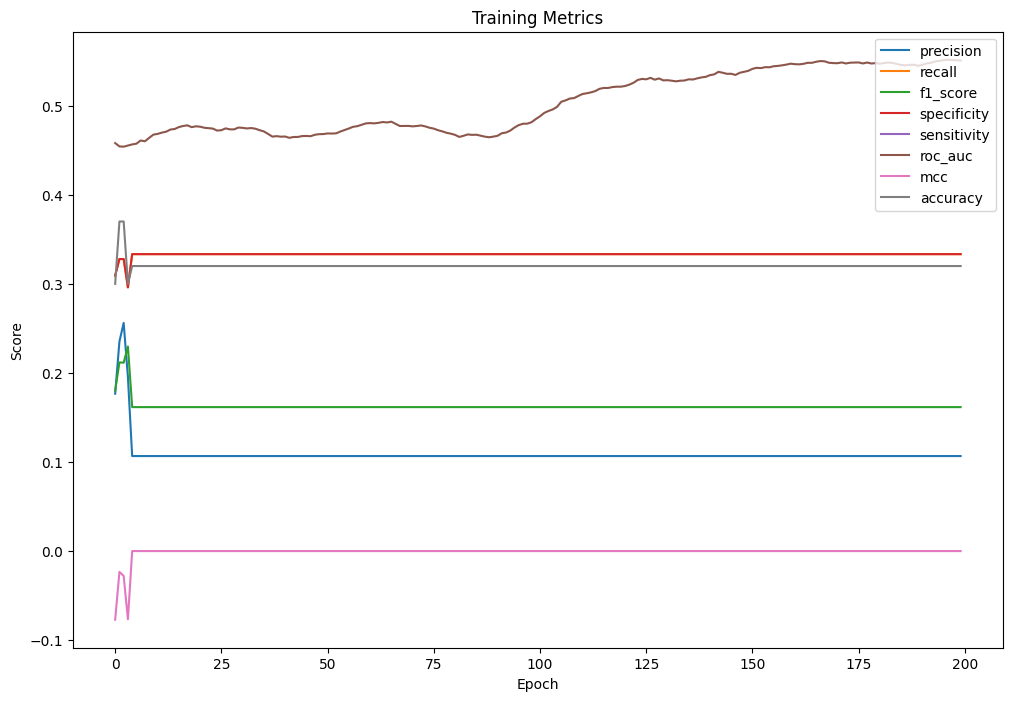

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Create a custom synthetic dataset with 500 nodes
class CustomDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(CustomDataset, self).__init__(None, transform)
        self.data, self.slices = self.process()

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return []

    def download(self):
        pass

    def process(self):
        num_nodes = 500
        num_node_features = 16
        num_classes = 3

        x = torch.randn((num_nodes, num_node_features), dtype=torch.float)
        edge_index = torch.randint(0, num_nodes, (2, 1000), dtype=torch.long)
        y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[:int(0.8 * num_nodes)] = True
        test_mask = ~train_mask

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
        data = self.transform(data) if self.transform else data

        return data, None

# Save dataset to JSON file
def save_dataset_to_json(data, filename):
    data_dict = {
        'x': data.x.tolist(),
        'edge_index': data.edge_index.tolist(),
        'y': data.y.tolist(),
        'train_mask': data.train_mask.tolist(),
        'test_mask': data.test_mask.tolist()
    }
    with open(filename, 'w') as f:
        json.dump(data_dict, f)

# Load dataset from JSON file
def load_dataset_from_json(filename):
    with open(filename, 'r') as f:
        data_dict = json.load(f)
    data = Data(
        x=torch.tensor(data_dict['x'], dtype=torch.float),
        edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
        y=torch.tensor(data_dict['y'], dtype=torch.long),
        train_mask=torch.tensor(data_dict['train_mask'], dtype=torch.bool),
        test_mask=torch.tensor(data_dict['test_mask'], dtype=torch.bool)
    )
    return data

# Create and save the dataset
dataset = CustomDataset(transform=NormalizeFeatures())
data = dataset[0]
save_dataset_to_json(data, 'benchmark.json')

# Load the dataset
data = load_dataset_from_json('synthetic_dataset.json')

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT(in_channels=data.num_node_features, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

metrics = {
    'precision': [],
    'recall': [],
    'f1_score': [],
    'specificity': [],
    'sensitivity': [],
    'roc_auc': [],
    'mcc': [],
    'accuracy': []
}

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()
        
        precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        roc_auc = roc_auc_score(y_true[data.test_mask], F.softmax(out[data.test_mask], dim=1).cpu().numpy(), multi_class='ovr')
        mcc = matthews_corrcoef(y_true[data.test_mask], y_pred[data.test_mask])
        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])
        
        cm = confusion_matrix(y_true[data.test_mask], y_pred[data.test_mask])
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=0))
        
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1_score'].append(f1)
        metrics['specificity'].append(specificity)
        metrics['sensitivity'].append(sensitivity)
        metrics['roc_auc'].append(roc_auc)
        metrics['mcc'].append(mcc)
        metrics['accuracy'].append(accuracy)

for epoch in range(200):
    loss = train()
    evaluate()
    print(f'Epoch {epoch}, Loss: {loss}')

# Plotting the metrics
plt.figure(figsize=(12, 8))
for metric, values in metrics.items():
    plt.plot(values, label=metric)
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Training Metrics')
plt.show()

Processing...
Done!


GAT Epoch 0, Loss: 1.1075959205627441, Accuracy: 0.37
GAT Epoch 1, Loss: 1.1060775518417358, Accuracy: 0.29
GAT Epoch 2, Loss: 1.1083574295043945, Accuracy: 0.29
GAT Epoch 3, Loss: 1.1098958253860474, Accuracy: 0.29
GAT Epoch 4, Loss: 1.1208990812301636, Accuracy: 0.29
GAT Epoch 5, Loss: 1.098200798034668, Accuracy: 0.29
GAT Epoch 6, Loss: 1.1054232120513916, Accuracy: 0.29
GAT Epoch 7, Loss: 1.102786660194397, Accuracy: 0.29
GAT Epoch 8, Loss: 1.0988434553146362, Accuracy: 0.29
GAT Epoch 9, Loss: 1.1102879047393799, Accuracy: 0.29
GAT Epoch 10, Loss: 1.1037768125534058, Accuracy: 0.29
GAT Epoch 11, Loss: 1.0976862907409668, Accuracy: 0.3
GAT Epoch 12, Loss: 1.0932999849319458, Accuracy: 0.34
GAT Epoch 13, Loss: 1.1100306510925293, Accuracy: 0.29
GAT Epoch 14, Loss: 1.1021132469177246, Accuracy: 0.29
GAT Epoch 15, Loss: 1.111938238143921, Accuracy: 0.29
GAT Epoch 16, Loss: 1.1014786958694458, Accuracy: 0.29
GAT Epoch 17, Loss: 1.1052732467651367, Accuracy: 0.29
GAT Epoch 18, Loss: 1.10

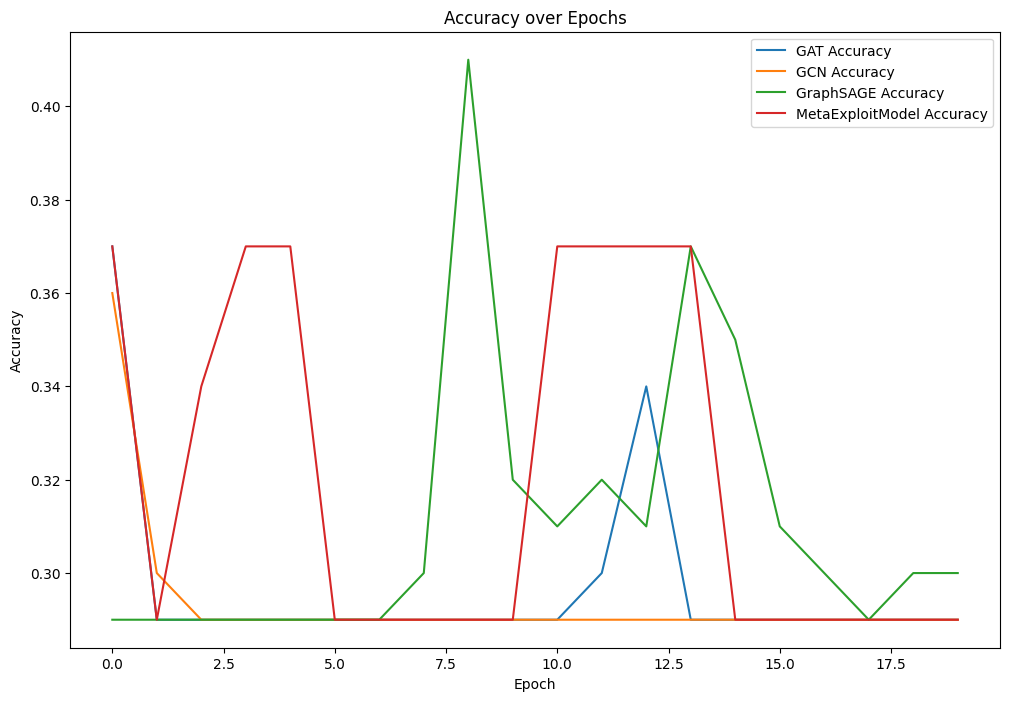


# Benchmark Table

| Epoch Range | GAT Accuracy | GCN Accuracy | GraphSAGE Accuracy | MetaExploitModel Accuracy |
|-------------|--------------|--------------|--------------------|---------------------------|
| 1-10 | 0.298 | 0.298 | 0.306 | 0.319 |
| 11-20 | 0.296 | 0.290 | 0.316 | 0.322 |
| 21-30 | 0.000 | 0.000 | 0.000 | 0.000 |
| 31-40 | 0.000 | 0.000 | 0.000 | 0.000 |
| 41-50 | 0.000 | 0.000 | 0.000 | 0.000 |
| 51-60 | 0.000 | 0.000 | 0.000 | 0.000 |
| 61-70 | 0.000 | 0.000 | 0.000 | 0.000 |
| 71-80 | 0.000 | 0.000 | 0.000 | 0.000 |
| 81-90 | 0.000 | 0.000 | 0.000 | 0.000 |
| 91-100 | 0.000 | 0.000 | 0.000 | 0.000 |
| 101-110 | 0.000 | 0.000 | 0.000 | 0.000 |
| 111-120 | 0.000 | 0.000 | 0.000 | 0.000 |
| 121-130 | 0.000 | 0.000 | 0.000 | 0.000 |
| 131-140 | 0.000 | 0.000 | 0.000 | 0.000 |
| 141-150 | 0.000 | 0.000 | 0.000 | 0.000 |
| 151-160 | 0.000 | 0.000 | 0.000 | 0.000 |
| 161-170 | 0.000 | 0.000 | 0.000 | 0.000 |
| 171-180 | 0.000 | 0.000 | 0.000 | 0.000 |
| 181-190 | 0.000 

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 

# Create a custom synthetic dataset with 500 nodes
class CustomDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(CustomDataset, self).__init__(None, transform)
        self.data, self.slices = self.process()

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return []

    def download(self):
        pass

    def process(self):
        num_nodes = 500
        num_node_features = 16
        num_classes = 3

        x = torch.randn((num_nodes, num_node_features), dtype=torch.float)
        edge_index = torch.randint(0, num_nodes, (2, 1000), dtype=torch.long)
        y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[:int(0.8 * num_nodes)] = True
        test_mask = ~train_mask

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
        data = self.transform(data) if self.transform else data

        return data, None

# Save dataset to JSON file
def save_dataset_to_json(data, filename):
    data_dict = {
        'x': data.x.tolist(),
        'edge_index': data.edge_index.tolist(),
        'y': data.y.tolist(),
        'train_mask': data.train_mask.tolist(),
        'test_mask': data.test_mask.tolist()
    }
    with open(filename, 'w') as f:
        json.dump(data_dict, f)

# Load dataset from JSON file
def load_dataset_from_json(filename):
    with open(filename, 'r') as f:
        data_dict = json.load(f)
    data = Data(
        x=torch.tensor(data_dict['x'], dtype=torch.float),
        edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
        y=torch.tensor(data_dict['y'], dtype=torch.long),
        train_mask=torch.tensor(data_dict['train_mask'], dtype=torch.bool),
        test_mask=torch.tensor(data_dict['test_mask'], dtype=torch.bool)
    )
    return data

# Create and save the dataset
dataset = CustomDataset(transform=NormalizeFeatures())
data = dataset[0]
save_dataset_to_json(data, 'synthetic_dataset.json')

# Load the dataset
data = load_dataset_from_json('synthetic_dataset.json')

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 2
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)

    def forward(self, data):
        adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
        adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
        print(f"adj_matrix shape: {adj_matrix.shape}")
        output = self.model(adj_matrix)
        return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')

        # Check if y_true and out have the same number of classes
        num_classes = out.shape[1]
        unique_labels = np.unique(y_true[data.test_mask])
        if len(unique_labels) == num_classes:
            roc_auc = roc_auc_score(y_true[data.test_mask], F.softmax(out[data.test_mask], dim=1).cpu().numpy(), multi_class='ovr')
        else:
            roc_auc = float('nan')  # Or handle this case as appropriate

        mcc = matthews_corrcoef(y_true[data.test_mask], y_pred[data.test_mask])
        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])

        cm = confusion_matrix(y_true[data.test_mask], y_pred[data.test_mask])
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

        # metrics['precision'].append(precision)
        # metrics['recall'].append(recall)
        # metrics['f1_score'].append(f1)
        # metrics['specificity'].append(specificity)
        # metrics['sensitivity'].append(sensitivity)
        # metrics['roc_auc'].append(roc_auc)
        # metrics['mcc'].append(mcc)
        metrics['accuracy'].append(accuracy)

# Initialize GAT model
gat_model = GAT(in_channels=data.num_node_features, out_channels=3)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)

# Initialize GCN model
gcn_model = GCN(in_channels=data.num_node_features, out_channels=3)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.005, weight_decay=5e-4)

# Initialize GraphSAGE model
graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=3)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.005, weight_decay=5e-4)

# Initialize MetaExploitModel
meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.005, weight_decay=5e-4)

# Metrics storage
gat_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

gcn_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

graph_sage_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

meta_exploit_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

# Train and evaluate GAT model
for epoch in range(20):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')

# Train and evaluate GCN model
for epoch in range(20):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')

# Train and evaluate GraphSAGE model
for epoch in range(20):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')

# Train and evaluate MetaExploitModel
for epoch in range(20):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='MetaExploitModel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()

# Generate benchmark table in markdown
benchmark_table = """
# Benchmark Table

| Epoch Range | GAT Accuracy | GCN Accuracy | GraphSAGE Accuracy | MetaExploitModel Accuracy |
|-------------|--------------|--------------|--------------------|---------------------------|
"""

for start_epoch in range(0, 200, 6):
    end_epoch = start_epoch + 10
    gat_acc = sum(gat_metrics['accuracy'][start_epoch:end_epoch]) / 10
    gcn_acc = sum(gcn_metrics['accuracy'][start_epoch:end_epoch]) / 10
    graph_sage_acc = sum(graph_sage_metrics['accuracy'][start_epoch:end_epoch]) / 10
    meta_exploit_acc = sum(meta_exploit_metrics['accuracy'][start_epoch:end_epoch]) / 10
    benchmark_table += f"| {start_epoch + 1}-{end_epoch} | {gat_acc:.3f} | {gcn_acc:.3f} | {graph_sage_acc:.3f} | {meta_exploit_acc:.3f} |\n"

print(benchmark_table)

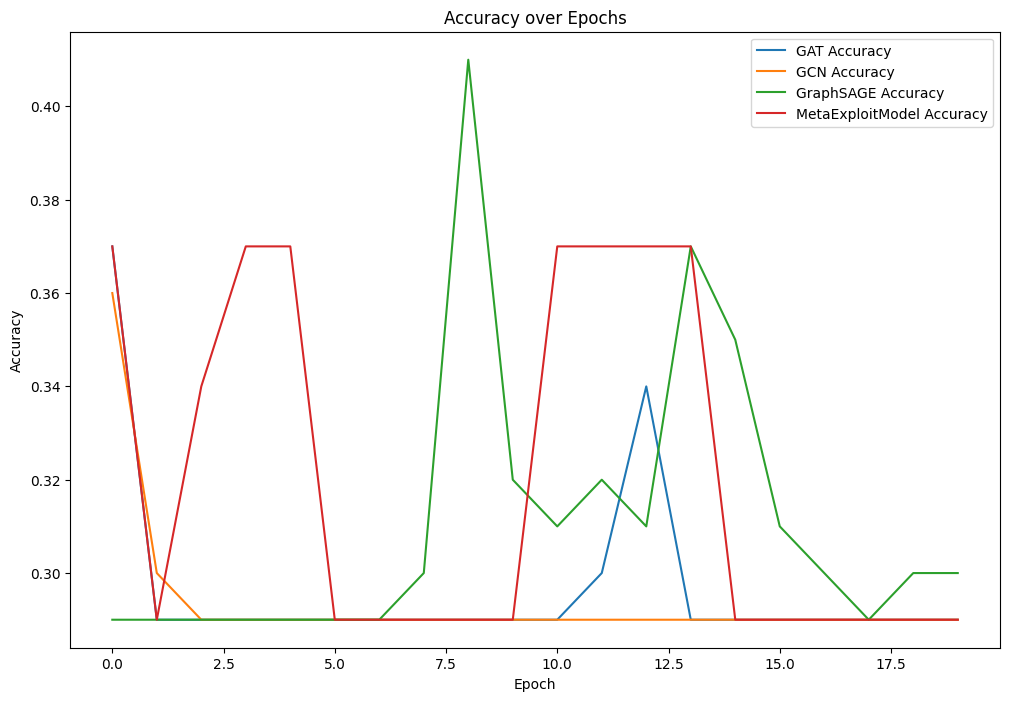

In [4]:
# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='MetaExploitModel Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

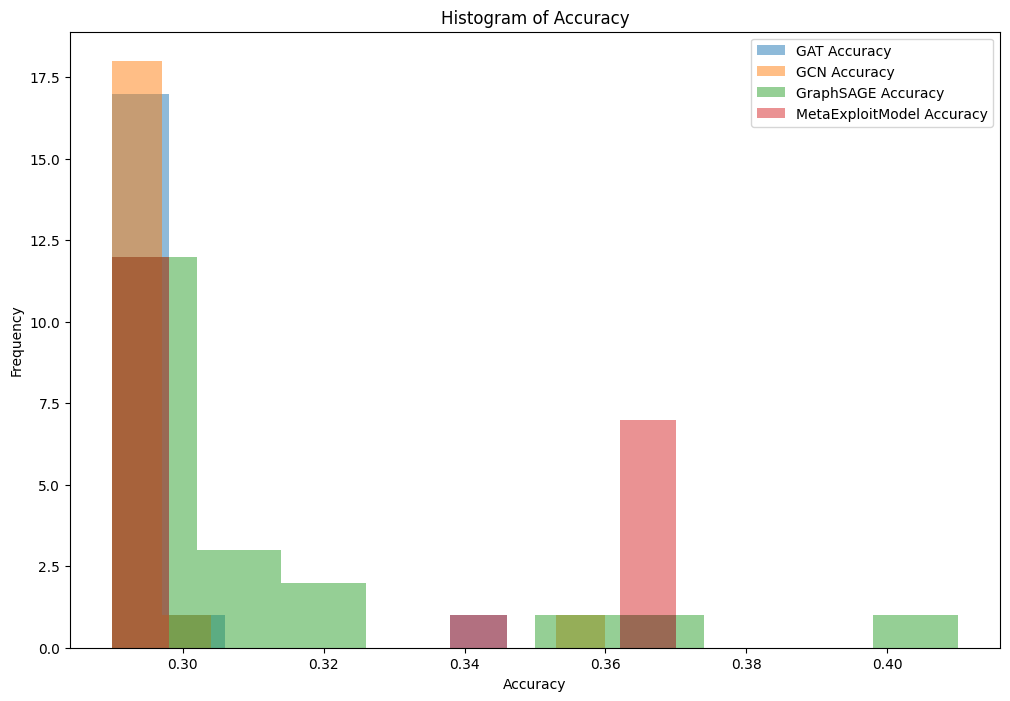

In [7]:
# Histogram of accuracy for each model
plt.figure(figsize=(12, 8))
plt.hist(gat_metrics['accuracy'], bins=10, alpha=0.5, label='GAT Accuracy')
plt.hist(gcn_metrics['accuracy'], bins=10, alpha=0.5, label='GCN Accuracy')
plt.hist(graph_sage_metrics['accuracy'], bins=10, alpha=0.5, label='GraphSAGE Accuracy')
plt.hist(meta_exploit_metrics['accuracy'], bins=10, alpha=0.5, label='MetaExploitModel Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Accuracy')
plt.show()

# working

In [37]:
# import torch
# import torch.nn.functional as F
# from torch_geometric.nn import GATConv, GCNConv, SAGEConv
# from torch_geometric.data import Data, InMemoryDataset
# from torch_geometric.transforms import NormalizeFeatures
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
# import matplotlib.pyplot as plt
# import numpy as np
# import json

# # Import GraphTransformer from core_rec.py
# from core_rec import GraphTransformer 

# # Create a custom synthetic dataset with 500 nodes
# class CustomDataset(InMemoryDataset):
#     def __init__(self, transform=None):
#         super(CustomDataset, self).__init__(None, transform)
#         self.data, self.slices = self.process()

#     @property
#     def raw_file_names(self):
#         return []

#     @property
#     def processed_file_names(self):
#         return []

#     def download(self):
#         pass

#     def process(self):
#         num_nodes = 500
#         num_node_features = 16
#         num_classes = 3

#         x = torch.randn((num_nodes, num_node_features), dtype=torch.float)
#         edge_index = torch.randint(0, num_nodes, (2, 1000), dtype=torch.long)
#         y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

#         train_mask = torch.zeros(num_nodes, dtype=torch.bool)
#         train_mask[:int(0.8 * num_nodes)] = True
#         test_mask = ~train_mask

#         data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)
#         data = self.transform(data) if self.transform else data

#         return data, None

# # Save dataset to JSON file
# def save_dataset_to_json(data, filename):
#     data_dict = {
#         'x': data.x.tolist(),
#         'edge_index': data.edge_index.tolist(),
#         'y': data.y.tolist(),
#         'train_mask': data.train_mask.tolist(),
#         'test_mask': data.test_mask.tolist()
#     }
#     with open(filename, 'w') as f:
#         json.dump(data_dict, f)

# # Load dataset from JSON file
# def load_dataset_from_json(filename):
#     with open(filename, 'r') as f:
#         data_dict = json.load(f)
#     data = Data(
#         x=torch.tensor(data_dict['x'], dtype=torch.float),
#         edge_index=torch.tensor(data_dict['edge_index'], dtype=torch.long),
#         y=torch.tensor(data_dict['y'], dtype=torch.long),
#         train_mask=torch.tensor(data_dict['train_mask'], dtype=torch.bool),
#         test_mask=torch.tensor(data_dict['test_mask'], dtype=torch.bool)
#     )
#     return data

# # Create and save the dataset
# dataset = CustomDataset(transform=NormalizeFeatures())
# data = dataset[0]
# save_dataset_to_json(data, 'synthetic_dataset.json')

# # Load the dataset
# data1 = load_dataset_from_json('synthetic_dataset.json')


Processing...
Done!


In [147]:
from torch_geometric.datasets import Planetoid

# Assuming your numpy array is named `data_array`
# data_array = np.loadtxt('data_mother/500label.csv', delimiter=',')
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
data_array = np.loadtxt('label.csv', delimiter=',')

# Convert numpy array to torch tensor
x = torch.tensor(data_array, dtype=torch.float)
num_nodes = x.size(0)
edge_index = torch.randint(0, num_nodes, (2, 1000), dtype=torch.long)

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index)

# Add train_mask and test_mask
num_nodes = x.size(0)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:int(0.8 * num_nodes)] = True
test_mask = ~train_mask

data.train_mask = train_mask
data.test_mask = test_mask

# Add labels (y) if not already present
num_classes = 3
data.y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)

# Now you can access num_node_features
gat_model = GAT(in_channels=data.num_node_features, out_channels=3)

Training Loss: 1.999417781829834
GAT Epoch 0, Loss: 1.999417781829834, Accuracy: 0.485
Training Loss: 1.9003219604492188
GAT Epoch 1, Loss: 1.9003219604492188, Accuracy: 0.703
Training Loss: 1.8262394666671753
GAT Epoch 2, Loss: 1.8262394666671753, Accuracy: 0.762
Training Loss: 1.6956545114517212
GAT Epoch 3, Loss: 1.6956545114517212, Accuracy: 0.781
Training Loss: 1.5411068201065063
GAT Epoch 4, Loss: 1.5411068201065063, Accuracy: 0.8
Training Loss: 1.51243257522583
GAT Epoch 5, Loss: 1.51243257522583, Accuracy: 0.796
Training Loss: 1.4734208583831787
GAT Epoch 6, Loss: 1.4734208583831787, Accuracy: 0.8
Training Loss: 1.3973232507705688
GAT Epoch 7, Loss: 1.3973232507705688, Accuracy: 0.789
Training Loss: 1.1886334419250488
GAT Epoch 8, Loss: 1.1886334419250488, Accuracy: 0.795
Training Loss: 1.2132275104522705
GAT Epoch 9, Loss: 1.2132275104522705, Accuracy: 0.79
Training Loss: 1.1072444915771484
GAT Epoch 10, Loss: 1.1072444915771484, Accuracy: 0.797
Training Loss: 1.07834362983703

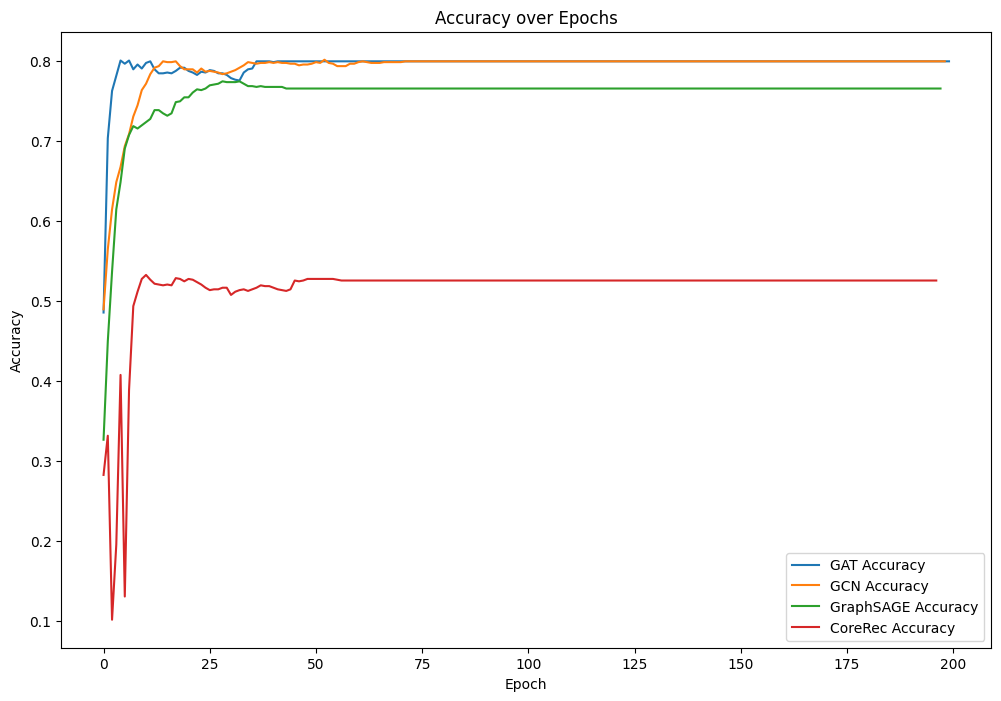

In [138]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, 8, heads=8, dropout=0.6)
        self.conv3 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 8
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)
    def forward(self, data):
            adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
            adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
            output = self.model(adj_matrix)
            return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Training Loss: {loss.item()}")
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')

        # Check if y_true and out have the same number of classes
        num_classes = out.shape[1]
        unique_labels = np.unique(y_true[data.test_mask])
        if len(unique_labels) == num_classes:
            roc_auc = roc_auc_score(y_true[data.test_mask], F.softmax(out[data.test_mask], dim=1).cpu().numpy(), multi_class='ovr')
        else:
            roc_auc = float('nan')  # Or handle this case as appropriate

        mcc = matthews_corrcoef(y_true[data.test_mask], y_pred[data.test_mask])
        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])

        cm = confusion_matrix(y_true[data.test_mask], y_pred[data.test_mask])
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

        # metrics['precision'].append(precision)
        # metrics['recall'].append(recall)
        # metrics['f1_score'].append(f1)
        # metrics['specificity'].append(specificity)
        # metrics['sensitivity'].append(sensitivity)
        # metrics['roc_auc'].append(roc_auc)
        # metrics['mcc'].append(mcc)
        metrics['accuracy'].append(accuracy)


# Initialize models and optimizers with the correct number of output classes
num_classes = dataset.num_classes

gat_model = GAT(in_channels=data.num_node_features, out_channels=num_classes)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
gat_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gat_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

gcn_model = GCN(in_channels=data.num_node_features, out_channels=num_classes)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gcn_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.01, weight_decay=5e-4)
graph_sage_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(graph_sage_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.01, weight_decay=5e-4)
meta_exploit_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(meta_exploit_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Metrics storage
gat_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

gcn_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

graph_sage_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

meta_exploit_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

# Early stopping parameters
patience = 10
best_loss = float('inf')
patience_counter = 0
epoch=200
# Train and evaluate GAT model
for epoch in range(epoch):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')
    gat_scheduler.step(loss)

# Train and evaluate GCN model
for epoch in range(epoch):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')
    gcn_scheduler.step(loss)

# Train and evaluate GraphSAGE model
for epoch in range(epoch):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')
    graph_sage_scheduler.step(loss)

# Train and evaluate MetaExploitModel with early stopping and learning rate scheduler
for epoch in range(epoch):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

    # Update learning rate scheduler
    meta_exploit_scheduler.step(loss)


# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='CoreRec Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()

In [139]:

# Generate benchmark table in markdown
benchmark_table = """
# Benchmark Table

| Epoch Range | GAT Accuracy | GCN Accuracy | GraphSAGE Accuracy | MetaExploitModel Accuracy |
|-------------|--------------|--------------|--------------------|---------------------------|
"""

for start_epoch in range(0, epoch, 10):
    end_epoch = start_epoch + 10
    gat_acc = sum(gat_metrics['accuracy'][start_epoch:end_epoch]) / 10
    gcn_acc = sum(gcn_metrics['accuracy'][start_epoch:end_epoch]) / 10
    graph_sage_acc = sum(graph_sage_metrics['accuracy'][start_epoch:end_epoch]) / 10
    meta_exploit_acc = sum(meta_exploit_metrics['accuracy'][start_epoch:end_epoch]) / 10
    benchmark_table += f"| {start_epoch + 1}-{end_epoch} | {gat_acc:.3f} | {gcn_acc:.3f} | {graph_sage_acc:.3f} | {meta_exploit_acc:.3f} |\n"

print(benchmark_table)


# Benchmark Table

| Epoch Range | GAT Accuracy | GCN Accuracy | GraphSAGE Accuracy | MetaExploitModel Accuracy |
|-------------|--------------|--------------|--------------------|---------------------------|
| 1-10 | 0.750 | 0.662 | 0.612 | 0.337 |
| 11-20 | 0.789 | 0.791 | 0.738 | 0.524 |
| 21-30 | 0.785 | 0.786 | 0.766 | 0.519 |
| 31-40 | 0.789 | 0.794 | 0.770 | 0.514 |
| 41-50 | 0.799 | 0.796 | 0.766 | 0.520 |
| 51-60 | 0.799 | 0.796 | 0.765 | 0.526 |
| 61-70 | 0.799 | 0.798 | 0.765 | 0.525 |
| 71-80 | 0.799 | 0.799 | 0.765 | 0.525 |
| 81-90 | 0.799 | 0.799 | 0.765 | 0.525 |
| 91-100 | 0.799 | 0.799 | 0.765 | 0.525 |
| 101-110 | 0.799 | 0.799 | 0.765 | 0.525 |
| 111-120 | 0.799 | 0.799 | 0.765 | 0.525 |
| 121-130 | 0.799 | 0.799 | 0.765 | 0.525 |
| 131-140 | 0.799 | 0.799 | 0.765 | 0.525 |
| 141-150 | 0.799 | 0.799 | 0.765 | 0.525 |
| 151-160 | 0.799 | 0.799 | 0.765 | 0.525 |
| 161-170 | 0.799 | 0.799 | 0.765 | 0.525 |
| 171-180 | 0.799 | 0.799 | 0.765 | 0.525 |
| 181-190 | 0.799 

Training Loss: 2.028071641921997
GAT Epoch 0, Loss: 2.028071641921997, Accuracy: 0.377
Training Loss: 1.8638440370559692
GAT Epoch 1, Loss: 1.8638440370559692, Accuracy: 0.541
Training Loss: 1.784907579421997
GAT Epoch 2, Loss: 1.784907579421997, Accuracy: 0.678
Training Loss: 1.682788372039795
GAT Epoch 3, Loss: 1.682788372039795, Accuracy: 0.733
Training Loss: 1.5528826713562012
GAT Epoch 4, Loss: 1.5528826713562012, Accuracy: 0.767
Training Loss: 1.4594589471817017
GAT Epoch 5, Loss: 1.4594589471817017, Accuracy: 0.79
Training Loss: 1.3105525970458984
GAT Epoch 6, Loss: 1.3105525970458984, Accuracy: 0.802
Training Loss: 1.2882438898086548
GAT Epoch 7, Loss: 1.2882438898086548, Accuracy: 0.817
Training Loss: 1.1798079013824463
GAT Epoch 8, Loss: 1.1798079013824463, Accuracy: 0.818
Training Loss: 1.1408194303512573
GAT Epoch 9, Loss: 1.1408194303512573, Accuracy: 0.809
Training Loss: 1.071595311164856
GAT Epoch 10, Loss: 1.071595311164856, Accuracy: 0.793
Training Loss: 0.976713001728

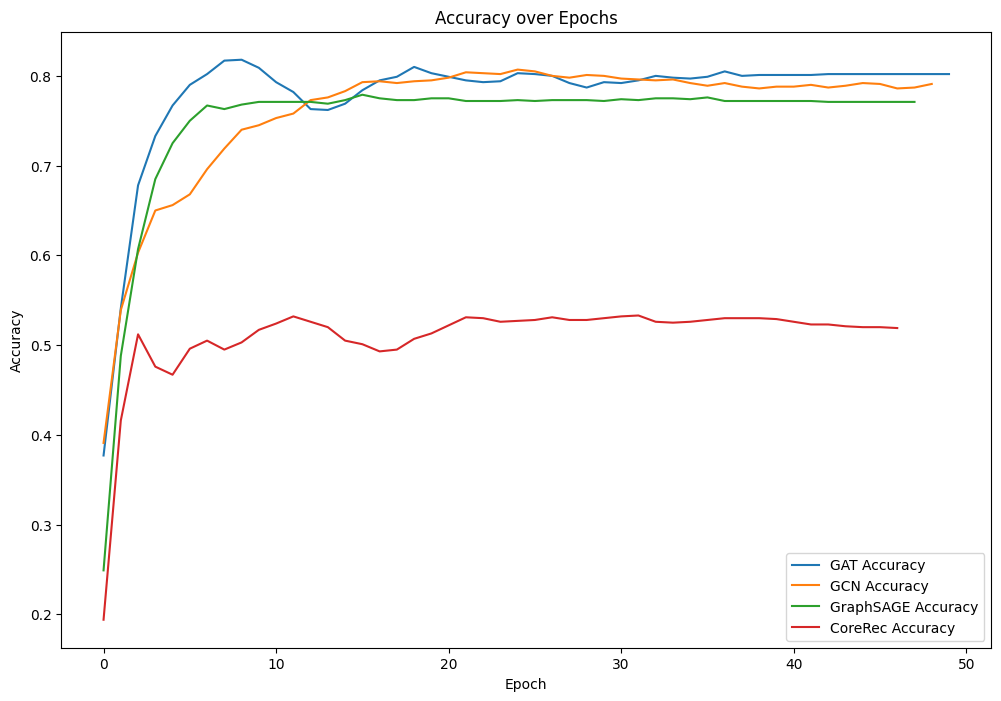

In [141]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, 8, heads=8, dropout=0.6)
        self.conv3 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 1
        d_model = 128
        num_heads = 8
        d_feedforward = 512
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)
    def forward(self, data):
            adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
            adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
            output = self.model(adj_matrix)
            return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Training Loss: {loss.item()}")
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        precision = precision_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        recall = recall_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')
        f1 = f1_score(y_true[data.test_mask], y_pred[data.test_mask], average='macro')

        # Check if y_true and out have the same number of classes
        num_classes = out.shape[1]
        unique_labels = np.unique(y_true[data.test_mask])
        if len(unique_labels) == num_classes:
            roc_auc = roc_auc_score(y_true[data.test_mask], F.softmax(out[data.test_mask], dim=1).cpu().numpy(), multi_class='ovr')
        else:
            roc_auc = float('nan')  # Or handle this case as appropriate

        mcc = matthews_corrcoef(y_true[data.test_mask], y_pred[data.test_mask])
        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])

        cm = confusion_matrix(y_true[data.test_mask], y_pred[data.test_mask])
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

        # metrics['precision'].append(precision)
        # metrics['recall'].append(recall)
        # metrics['f1_score'].append(f1)
        # metrics['specificity'].append(specificity)
        # metrics['sensitivity'].append(sensitivity)
        # metrics['roc_auc'].append(roc_auc)
        # metrics['mcc'].append(mcc)
        metrics['accuracy'].append(accuracy)


# Initialize models and optimizers with the correct number of output classes
num_classes = dataset.num_classes

gat_model = GAT(in_channels=data.num_node_features, out_channels=num_classes)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
gat_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gat_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

gcn_model = GCN(in_channels=data.num_node_features, out_channels=num_classes)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gcn_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.01, weight_decay=5e-4)
graph_sage_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(graph_sage_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.01, weight_decay=5e-4)
meta_exploit_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(meta_exploit_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Metrics storage
gat_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

gcn_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

graph_sage_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

meta_exploit_metrics = {
    # 'precision': [],
    # 'recall': [],
    # 'f1_score': [],
    # 'specificity': [],
    # 'sensitivity': [],
    # 'roc_auc': [],
    # 'mcc': [],
    'accuracy': []
}

# Early stopping parameters
patience = 10
best_loss = float('inf')
patience_counter = 0
epoch=50
# Train and evaluate GAT model
for epoch in range(epoch):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')
    gat_scheduler.step(loss)

# Train and evaluate GCN model
for epoch in range(epoch):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')
    gcn_scheduler.step(loss)

# Train and evaluate GraphSAGE model
for epoch in range(epoch):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')
    graph_sage_scheduler.step(loss)

# Train and evaluate MetaExploitModel with early stopping and learning rate scheduler
for epoch in range(epoch):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

    # Update learning rate scheduler
    meta_exploit_scheduler.step(loss)


# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='CoreRec Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()

Training Loss: 2.06669282913208
Evaluation Accuracy: 0.376
GAT Epoch 0, Loss: 2.06669282913208, Accuracy: 0.376
Training Loss: 1.8919607400894165
Evaluation Accuracy: 0.404
GAT Epoch 1, Loss: 1.8919607400894165, Accuracy: 0.404
Training Loss: 1.8362239599227905
Evaluation Accuracy: 0.483
GAT Epoch 2, Loss: 1.8362239599227905, Accuracy: 0.483
Training Loss: 1.7372714281082153
Evaluation Accuracy: 0.599
GAT Epoch 3, Loss: 1.7372714281082153, Accuracy: 0.599
Training Loss: 1.5785287618637085
Evaluation Accuracy: 0.696
GAT Epoch 4, Loss: 1.5785287618637085, Accuracy: 0.696
Training Loss: 1.5214605331420898
Evaluation Accuracy: 0.727
GAT Epoch 5, Loss: 1.5214605331420898, Accuracy: 0.727
Training Loss: 1.4122518301010132
Evaluation Accuracy: 0.749
GAT Epoch 6, Loss: 1.4122518301010132, Accuracy: 0.749
Training Loss: 1.3593660593032837
Evaluation Accuracy: 0.754
GAT Epoch 7, Loss: 1.3593660593032837, Accuracy: 0.754
Training Loss: 1.4044538736343384
Evaluation Accuracy: 0.756
GAT Epoch 8, Lo

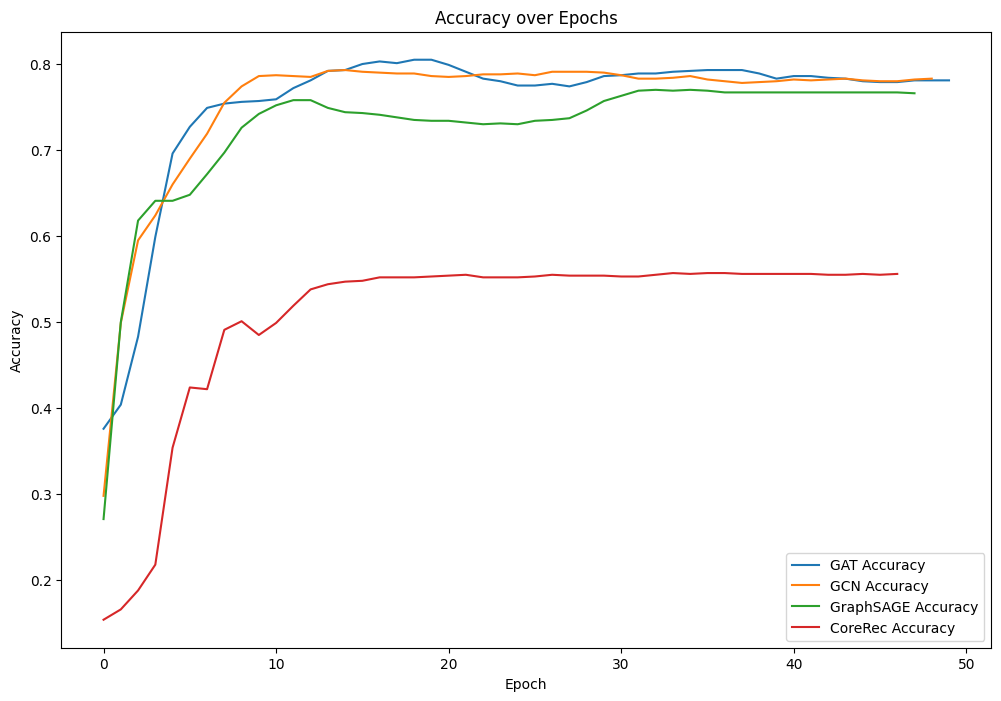

In [146]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, 8, heads=8, dropout=0.6)
        self.conv3 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 4  # Increase the number of layers
        d_model = 256  # Increase the model dimension
        num_heads = 8  # Adjust the number of heads
        d_feedforward = 1024  # Increase the feedforward dimension
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)
    def forward(self, data):
            adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
            adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
            output = self.model(adj_matrix)
            return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
        print(f"MetaExploitModel output (train): {out[data.train_mask]}")
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Training Loss: {loss.item()}")
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
            print(f"MetaExploitModel output (eval): {out[data.test_mask]}")
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])
        print(f"Evaluation Accuracy: {accuracy}")

        metrics['accuracy'].append(accuracy)


# Initialize models and optimizers with the correct number of output classes
num_classes = dataset.num_classes

gat_model = GAT(in_channels=data.num_node_features, out_channels=num_classes)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
gat_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gat_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

gcn_model = GCN(in_channels=data.num_node_features, out_channels=num_classes)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gcn_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.01, weight_decay=5e-4)
graph_sage_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(graph_sage_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.001, weight_decay=5e-4)  # Adjusted learning rate
meta_exploit_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(meta_exploit_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Metrics storage
gat_metrics = {
    'accuracy': []
}

gcn_metrics = {
    'accuracy': []
}

graph_sage_metrics = {
    'accuracy': []
}

meta_exploit_metrics = {
    'accuracy': []
}

# Early stopping parameters
patience = 10
best_loss = float('inf')
patience_counter = 0
epoch=50
# Train and evaluate GAT model
for epoch in range(epoch):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')
    gat_scheduler.step(loss)

# Train and evaluate GCN model
for epoch in range(epoch):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')
    gcn_scheduler.step(loss)

# Train and evaluate GraphSAGE model
for epoch in range(epoch):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')
    graph_sage_scheduler.step(loss)

# Train and evaluate MetaExploitModel with early stopping and learning rate scheduler
for epoch in range(epoch):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

    # Update learning rate scheduler
    meta_exploit_scheduler.step(loss)

# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='CoreRec Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()

Training Loss: 10.614036560058594
Evaluation Accuracy: 0.3333333333333333
GAT Epoch 0, Loss: 10.614036560058594, Accuracy: 0.3333333333333333
Training Loss: 4.884310722351074
Evaluation Accuracy: 0.3333333333333333
GAT Epoch 1, Loss: 4.884310722351074, Accuracy: 0.3333333333333333
Training Loss: 15.82253646850586
Evaluation Accuracy: 0.3333333333333333
GAT Epoch 2, Loss: 15.82253646850586, Accuracy: 0.3333333333333333
Training Loss: 42.58422088623047
Evaluation Accuracy: 0.3333333333333333
GAT Epoch 3, Loss: 42.58422088623047, Accuracy: 0.3333333333333333
Training Loss: 2.091000556945801
Evaluation Accuracy: 0.3333333333333333
GAT Epoch 4, Loss: 2.091000556945801, Accuracy: 0.3333333333333333
Training Loss: 7.857712745666504
Evaluation Accuracy: 0.3333333333333333
GAT Epoch 5, Loss: 7.857712745666504, Accuracy: 0.3333333333333333
Training Loss: 4.8978800773620605
Evaluation Accuracy: 0.3333333333333333
GAT Epoch 6, Loss: 4.8978800773620605, Accuracy: 0.3333333333333333
Training Loss: 5

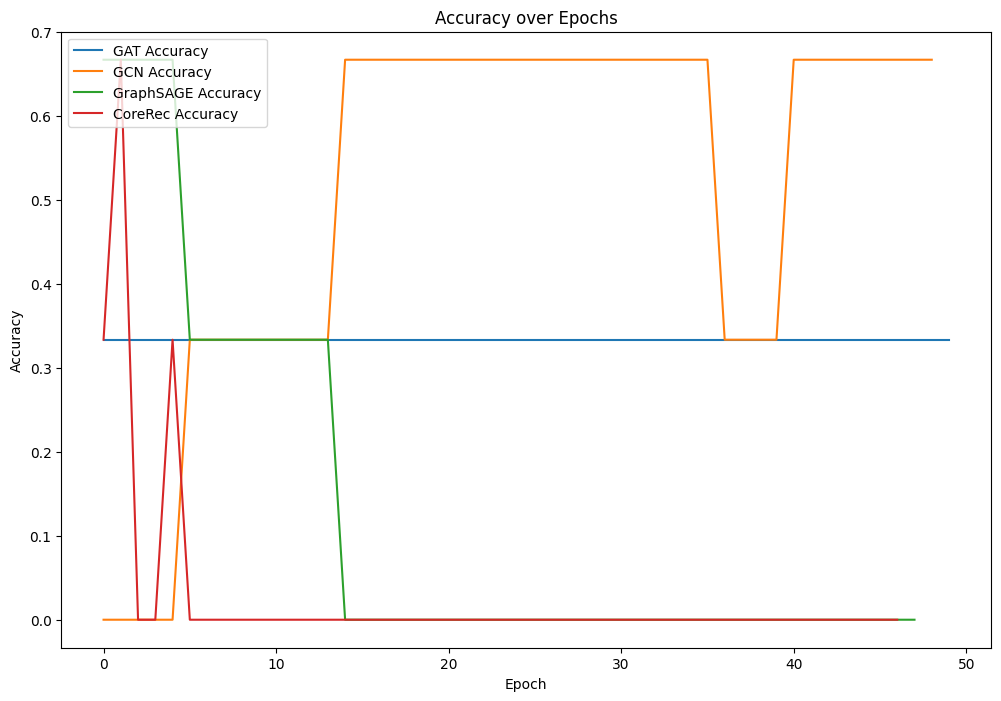

In [162]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import json

# Import GraphTransformer from core_rec.py
from core_rec import GraphTransformer 
import pandas as pd

class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        self.conv2 = GATConv(8 * 8, 8, heads=8, dropout=0.6)
        self.conv3 = GATConv(8 * 8, out_channels, heads=1, concat=True, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MetaExploitModel
class MetaExploitModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MetaExploitModel, self).__init__()
        num_layers = 4  # Increase the number of layers
        d_model = 256  # Increase the model dimension
        num_heads = 8  # Adjust the number of heads
        d_feedforward = 1024  # Increase the feedforward dimension
        self.model = GraphTransformer(num_layers, d_model, num_heads, d_feedforward, input_dim, use_weights=True)
    def forward(self, data):
            adj_matrix = data.x.numpy()  # Assuming data.x is the adjacency matrix
            adj_matrix = torch.tensor(adj_matrix, dtype=torch.float32)
            output = self.model(adj_matrix)
            return F.log_softmax(output, dim=1)

def train(model, optimizer, is_meta_exploit=False):
    model.train()
    optimizer.zero_grad()
    if is_meta_exploit:
        out = model(data)
        print(f"MetaExploitModel output (train): {out[data.train_mask]}")
    else:
        out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Training Loss: {loss.item()}")
    return loss.item()

def evaluate(model, metrics, is_meta_exploit=False):
    model.eval()
    with torch.no_grad():
        if is_meta_exploit:
            out = model(data)
            out = out.view(data.num_nodes, -1)  # Ensure the output shape matches the number of nodes and classes
            print(f"MetaExploitModel output (eval): {out[data.test_mask]}")
        else:
            out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        y_true = data.y.cpu().numpy()
        y_pred = pred.cpu().numpy()

        accuracy = accuracy_score(y_true[data.test_mask], y_pred[data.test_mask])
        print(f"Evaluation Accuracy: {accuracy}")

        metrics['accuracy'].append(accuracy)


# Initialize models and optimizers with the correct number of output classes
num_classes = dataset.num_classes

gat_model = GAT(in_channels=data.num_node_features, out_channels=num_classes)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
gat_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gat_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

gcn_model = GCN(in_channels=data.num_node_features, out_channels=num_classes)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(gcn_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

graph_sage_model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)
graph_sage_optimizer = torch.optim.Adam(graph_sage_model.parameters(), lr=0.01, weight_decay=5e-4)
graph_sage_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(graph_sage_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

meta_exploit_model = MetaExploitModel(input_dim=data.num_node_features)
meta_exploit_optimizer = torch.optim.Adam(meta_exploit_model.parameters(), lr=0.001, weight_decay=5e-4)  # Adjusted learning rate
meta_exploit_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(meta_exploit_optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Metrics storage
gat_metrics = {
    'accuracy': []
}

gcn_metrics = {
    'accuracy': []
}

graph_sage_metrics = {
    'accuracy': []
}

meta_exploit_metrics = {
    'accuracy': []
}

# Early stopping parameters
patience = 10
best_loss = float('inf')
patience_counter = 0
epoch=50
# Train and evaluate GAT model
for epoch in range(epoch):
    loss = train(gat_model, gat_optimizer)
    evaluate(gat_model, gat_metrics)
    print(f'GAT Epoch {epoch}, Loss: {loss}, Accuracy: {gat_metrics["accuracy"][-1]}')
    gat_scheduler.step(loss)

# Train and evaluate GCN model
for epoch in range(epoch):
    loss = train(gcn_model, gcn_optimizer)
    evaluate(gcn_model, gcn_metrics)
    print(f'GCN Epoch {epoch}, Loss: {loss}, Accuracy: {gcn_metrics["accuracy"][-1]}')
    gcn_scheduler.step(loss)

# Train and evaluate GraphSAGE model
for epoch in range(epoch):
    loss = train(graph_sage_model, graph_sage_optimizer)
    evaluate(graph_sage_model, graph_sage_metrics)
    print(f'GraphSAGE Epoch {epoch}, Loss: {loss}, Accuracy: {graph_sage_metrics["accuracy"][-1]}')
    graph_sage_scheduler.step(loss)

# Train and evaluate MetaExploitModel with early stopping and learning rate scheduler
for epoch in range(epoch):
    loss = train(meta_exploit_model, meta_exploit_optimizer, is_meta_exploit=True)
    evaluate(meta_exploit_model, meta_exploit_metrics, is_meta_exploit=True)
    print(f'MetaExploitModel Epoch {epoch}, Loss: {loss}, Accuracy: {meta_exploit_metrics["accuracy"][-1]}')

    # Update learning rate scheduler
    meta_exploit_scheduler.step(loss)

# Save metrics to JSON file
metrics_dict = {
    'GAT': gat_metrics,
    'GCN': gcn_metrics,
    'GraphSAGE': graph_sage_metrics,
    'MetaExploitModel': meta_exploit_metrics
}
with open('metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# Plotting the accuracy metrics
plt.figure(figsize=(12, 8))
plt.plot(gat_metrics['accuracy'], label='GAT Accuracy')
plt.plot(gcn_metrics['accuracy'], label='GCN Accuracy')
plt.plot(graph_sage_metrics['accuracy'], label='GraphSAGE Accuracy')
plt.plot(meta_exploit_metrics['accuracy'], label='CoreRec Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')   
plt.show()